### A/B Test – Recommendation System Algorithm Update  
#### Statistical Testing 

This notebook conducts formal hypothesis testing to evaluate whether the updated recommendation algorithm leads to statistically significant differences in user engagement compared to the existing system.

Building on the cleaned dataset and exploratory analysis, inference is performed at the user level, consistent with the experiment’s randomization design. Two-sided hypothesis tests are applied at a significance level of α = 0.05.

For each metric, the hypotheses are defined as:

- Null Hypothesis (H₀): There is no difference in the metric between the control and treatment groups.
- Alternative Hypothesis (Hₐ): There is a difference in the metric between the control and treatment groups.

Primary metrics:
- User-level Click-Through Rate (CTR)
- 7-day Return Rate

Secondary metrics:
- User-level Completion Rate
- Average Minutes Watched per Session (user-level)

The objective of this phase is to determine whether observed differences between the control and treatment groups are statistically significant and to quantify the magnitude of those differences.

#### 1. Imports and Data Loading

This section initializes the required statistical libraries and loads the cleaned dataset.  
The reusable data loader is used to ensure consistent schema enforcement across notebooks.


In [1]:
# Import core libraries for statistical testing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Import reusable data loader
import sys
import os
sys.path.append(os.path.abspath(".."))

from src.data_loader import load_cleaned_data

# Load cleaned dataset
df = load_cleaned_data()

In [3]:
# Confirm dataset shape
print(f"Dataset shape: {df.shape}")

Dataset shape: (147669, 17)


#### 2. User-Level Metric Construction

Because randomization occurred at the user level, all statistical inference must be performed using user-level aggregated metrics.

This section constructs the following user-level variables:

- User-level Click-Through Rate (CTR)
- 7-day Return Indicator
- User-level Completion Rate
- Average Minutes Watched per Session

The resulting dataset represents one observation per user and will serve as the basis for hypothesis testing.


In [4]:
# Aggregate session-level data to user level
user_df = (
    df.groupby("user_id", observed=True)
      .agg(
          group=("group", "first"),
          total_impressions=("impressions", "sum"),
          total_clicks=("clicks", "sum"),
          total_content_started=("content_started", "sum"),
          total_content_completed=("content_completed", "sum"),
          total_watch_time=("total_watch_time_minutes", "sum"),
          total_sessions=("session_id", "count"),
          first_session=("session_start", "min"),
          last_session=("session_start", "max")
      )
      .reset_index()
)

In [5]:
# Import metric computation functions from src/metrics.py
from src.metrics import (
    compute_user_ctr,
    compute_7day_return_flag,
    compute_user_completion_rate,
    compute_avg_minutes_watched
)

In [6]:
# Compute User_level CTR
user_df["user_ctr"] = compute_user_ctr(
    total_clicks=user_df["total_clicks"],
    total_impressions=user_df["total_impressions"]
)

# Compute 7-Day Return Indicator
# Generate return flag from full session-level dataset
return_flag = compute_7day_return_flag(df)

# Merge return flag into user-level dataset
user_df = user_df.merge(
    return_flag.rename("returned_within_7_days"),
    on="user_id",
    how="left"
)

# Users with no return event are assigned 0
user_df["returned_within_7_days"] = (
    user_df["returned_within_7_days"]
    .fillna(0)
    .astype(int)
)

# Compute User-Level Completion Rate
user_df["user_completion_rate"] = compute_user_completion_rate(
    total_completed=user_df["total_content_completed"],
    total_started=user_df["total_content_started"]
)

# Compute User-Level Average Minutes Watched per Session
user_df["avg_minutes_watched"] = compute_avg_minutes_watched(
    total_watch_time=user_df["total_watch_time"],
    total_sessions=user_df["total_sessions"]
)

In [7]:
# Sort user-level dataframe by numeric user_id for clearer display
user_df = user_df.sort_values(by="user_id", key=lambda x: x.astype(int)).reset_index(drop=True)

# Display first five rows
user_df.head()   

,user_id,group,total_impressions,total_clicks,total_content_started,total_content_completed,total_watch_time,total_sessions,first_session,last_session,user_ctr,returned_within_7_days,user_completion_rate,avg_minutes_watched
0,1,control,107,12,11,9,176.29,6,2026-01-03 11:13:01.347082148,2026-01-17 00:53:36.354677162,0.112150,1,0.818182,29.381667
1,2,treatment,176,32,30,13,251.05,8,2026-01-05 14:57:54.261910656,2026-01-20 14:18:51.515044869,0.181818,1,0.433333,31.381250
2,3,treatment,234,33,29,14,338.94,11,2026-01-03 05:22:32.449521299,2026-01-20 16:54:14.307980693,0.141026,1,0.482759,30.812727
3,4,treatment,86,9,8,6,308.90,5,2026-01-04 18:47:58.126068735,2026-01-17 18:57:46.818191863,0.104651,1,0.750000,61.780000
4,5,control,153,30,28,19,271.88,8,2026-01-03 00:23:39.830004774,2026-01-21 03:45:08.749071724,0.196078,1,0.678571,33.985000


In [8]:
# Check missing values
print("Missing values per column:")
print(user_df.isnull().sum())

Missing values per column:
user_id                    0
group                      0
total_impressions          0
total_clicks               0
total_content_started      0
total_content_completed    0
total_watch_time           0
total_sessions             0
first_session              0
last_session               0
user_ctr                   0
returned_within_7_days     0
user_completion_rate       0
avg_minutes_watched        0
dtype: int64


In [9]:
# Confirm one row per unique user
print("Unique users in original data:", df["user_id"].nunique())
print("Rows in user-level dataset:", user_df.shape[0])

Unique users in original data: 24495
Rows in user-level dataset: 24495


In [10]:
# Check metrics ranges
print("CTR range:", user_df["user_ctr"].min(), "to", user_df["user_ctr"].max())
print("Return rate values:", user_df["returned_within_7_days"].unique())
print("Completion rate range:", user_df["user_completion_rate"].min(), "to", user_df["user_completion_rate"].max())
print("Average minutes watched:", user_df["avg_minutes_watched"].min(), "to", user_df["avg_minutes_watched"].max())

CTR range: 0.0 to 0.47619047619047616
Return rate values: [1 0]
Completion rate range: 0.0 to 1.0
Average minutes watched: 2.52 to 106.83


In [11]:
# Save the user-level aggregated DataFrame to the processed data directory (exclude row index)
output_path = "../data/processed/aggregated_streaming_ab_test.csv"
user_df.to_csv(output_path, index=False)

# Confirm successful export
print(f"Cleaned dataset saved to: {output_path}")

Cleaned dataset saved to: ../data/processed/aggregated_streaming_ab_test.csv


#### Summary of User-Level Metric Construction

The aggregated dataset contains one observation per user (24,495 users), consistent with the experiment’s randomization design.

All user-level metrics fall within logically valid ranges:
- CTR: 0 to ~0.48
- Return Indicator: binary (0/1)
- Completion Rate: 0.0 to 1.0
- Average minutes watched: 2.52 to 106.83

The dataset is fully prepared for statistical inference.

#### 3. Assumption Checks for Continuous Metrics

This section assesses whether parametric two-sample t-tests are appropriate for the continuous engagement metrics (Click-Through Rate (CTR), Completion Rate and Average Minutes Watched per Session).

Because the experiment compares two independent user groups (control and treatment), mean differences will be evaluated using Welch's two-sample t-test, which does not assume equal variances between groups. 

Before proceeding, the following assumptions are examined:

- Independence of observations within and between groups
- Continuous outcome variable
- Approximate normality of the outcome within each group (or sufficiently large sample size for Central Limit Theorem robustness)
  
These checks ensure that the statistical testing framework is appropriate for the data structure.

##### 3.1. Independence of observations within and between groups

Randomization occurred at the user level, and each user was exposed to only one algorithm variant throughout the experiment. Therefore, observations within and between the control and treatment groups are treated as independent.

##### 3.2. Continuous outcome variable

In [12]:
# Count the number of unique values
print("Unique values in CTR:", user_df["user_ctr"].nunique())
print("Unique values in Completion Rate:",user_df["user_completion_rate"].nunique())
print("Unique values in Avg Minutes:",user_df["total_watch_time"].nunique())

Unique values in CTR: 2633
Unique values in Completion Rate: 358
Unique values in Avg Minutes: 19550


##### 3.3. Approximate normality

###### 3.3.1. Click-Through Rate (CTR)

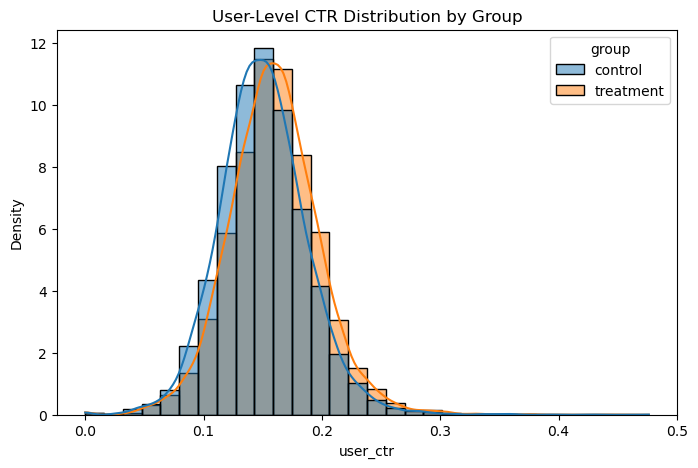

In [13]:
# Visualize distribution of user-level CTR by group
plt.figure(figsize=(8,5))
sns.histplot(data=user_df, x="user_ctr", hue="group", bins=30, kde=True, stat="density", common_norm=False)
plt.title("User-Level CTR Distribution by Group")
plt.show()

###### 3.3.2. Completion Rate

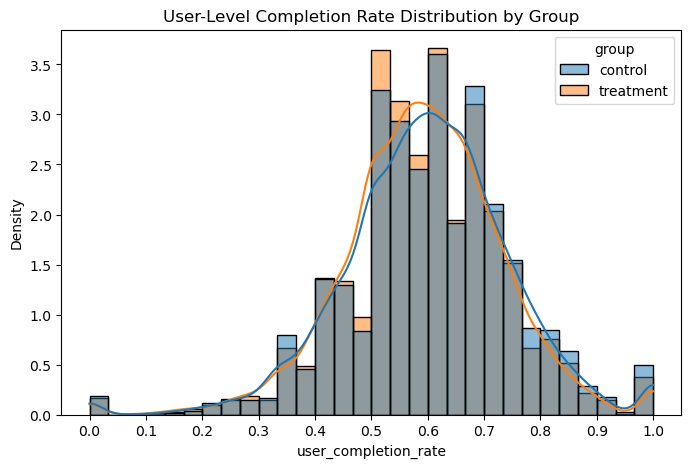

In [14]:
# Visualize distribution of user-level Completion Rate by group
plt.figure(figsize=(8,5))
sns.histplot(data=user_df, x="user_completion_rate", hue="group", bins=30, stat="density", kde=True, common_norm=False)
plt.title("User-Level Completion Rate Distribution by Group")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()

###### 3.3.3. Average Minutes Watched per Session

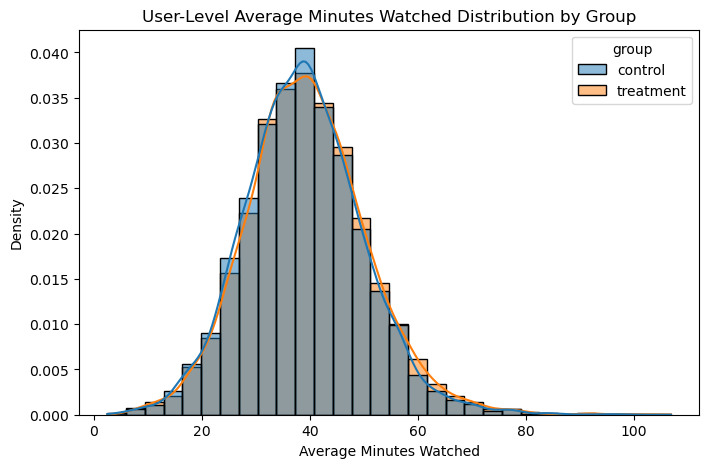

In [15]:
# Visualize distribution of user-level Completion Rate by group
plt.figure(figsize=(8,5))
sns.histplot(data=user_df, x="avg_minutes_watched", hue="group", bins=30, kde=True, stat="density", common_norm=False)
plt.title("User-Level Average Minutes Watched Distribution by Group")
plt.xlabel("Average Minutes Watched")
plt.show()

#### Summary of Assumption Checks for Continuous Metrics

- Observations are independent due to user-level randomization.
- The engagement metrics exhibit a large number of distinct numeric values at the user level and are therefore treated as continuous outcomes.
- User-level CTR shows mild right skewness but no extreme irregularities.
- Completion Rate is bounded (0–1) with expected discrete clustering and no extreme irregularities.
- Average Minutes Watched per Session is approximately bell-shaped with mild right skewness.
- No distribution exhibits severe skewness or extreme outliers that would invalidate large-sample inference.

Overall, the assumptions required for applying Welch's two-sample t-tests to continuous engagement metrics are reasonably satisfied.

#### 4. Hypothesis Testing – Continuous Metrics
This section evaluates whether statistically significant differences exist between the control and treatment groups for continuous engagement metrics.

Two-sided Welch’s two-sample t-tests are applied to compare mean outcomes between independent user groups.

##### 4.1. Click-Through Rate (Primary Metric)

- H₀: The mean user-level CTR is equal between control and treatment groups.
- Hₐ: The mean user-level CTR differs between control and treatment groups.

Significance level: α = 0.05

In [16]:
# Separate CTR values by group
ctr_control = user_df.loc[user_df["group"] == "control", "user_ctr"]
ctr_treatment = user_df.loc[user_df["group"] == "treatment", "user_ctr"]

# Display sample sizes
print("Control sample size:", ctr_control.shape[0])
print("Treatment sample size:", ctr_treatment.shape[0])

Control sample size: 12185
Treatment sample size: 12310


In [17]:
# Compute group means
ctr_control_mean = ctr_control.mean()
ctr_treatment_mean = ctr_treatment.mean()

print("Mean CTR Rate - Control:", ctr_control_mean)
print("Mean CTR Rate - Treatment:", ctr_treatment_mean)

Mean CTR Rate - Control: 0.15029703196660396
Mean CTR Rate - Treatment: 0.15966238932486804


In [18]:
# Calculate mean difference in CTR between treatment and control
ctr_mean_diff = ctr_treatment_mean - ctr_control_mean
print("Mean Difference (Treatment - Control):", ctr_mean_diff)

Mean Difference (Treatment - Control): 0.009365357358264076


In [19]:
# Perform two-sided Welch's t-test
ctr_t_stat, ctr_p_value = stats.ttest_ind(ctr_treatment, ctr_control, equal_var=False)

print("T-statistic:", ctr_t_stat)
print("P-value:", ctr_p_value)

T-statistic: 19.348475170350437
P-value: 8.725192537596908e-83


In [20]:
# Compute sample variances for each group
var_control = ctr_control.var(ddof=1)
var_treatment = ctr_treatment.var(ddof=1)

# Get sample sizes
n_control = len(ctr_control)
n_treatment = len(ctr_treatment)

# Calculate standard error of the mean difference
standard_error = np.sqrt(var_control/n_control + var_treatment/n_treatment)

print("Standard Error:",standard_error)

Standard Error: 0.00048403593956672825


In [21]:
# Compute Welch–Satterthwaite degrees of freedom
df_welch = (
    (var_control/n_control + var_treatment/n_treatment)**2 /
    ((var_control**2)/((n_control**2)*(n_control-1)) +
     (var_treatment**2)/((n_treatment**2)*(n_treatment-1)))
)

# Obtain critical t-value for 95% confidence level
t_critical = stats.t.ppf(0.975, df_welch)

# Calculate confidence interval bounds
ctr_ci_lower = ctr_mean_diff - t_critical * standard_error
ctr_ci_upper = ctr_mean_diff + t_critical * standard_error

print("95% Confidence Interval:", (ctr_ci_lower, ctr_ci_upper))

95% Confidence Interval: (np.float64(0.008416617439190172), np.float64(0.01031409727733798))


##### **Summary – Click-Through Rate (CTR)**

- **Mean CTR (Control):** 0.1503
- **Mean CTR (Treatment):** 0.1597
- **Mean Difference (Treatment − Control):** 0.0094
- **T-statistic:** 19.35
- **p-value:** < 0.001
- **Standard error:** 0.0005
- **95% Confidence Interval:** (0.0084, 0.0103)

A two-sided Welch’s t-test indicates a **statistically significant increase in user-level CTR** in the treatment algorithm compared to the control group.

Because the p-value is below the significance level (α = 0.05) **The null hypothesis is rejected.** The estimated lift is approximately 0.94 percentage points, suggesting that the updated recommendation algorithm improves click-through performance.

##### 4.2. Completion Rate (Secondary Metric)

- H₀: The mean user-level Completion Rate is equal between control and treatment groups.
- Hₐ: The mean user-level Completion Rate differs between control and treatment groups.

Significance level: α = 0.05

In [22]:
# Separate Completion Rate values by group
comp_control = user_df.loc[user_df["group"] == "control", "user_completion_rate"]
comp_treatment = user_df.loc[user_df["group"] == "treatment", "user_completion_rate"]

# Display sample sizes
print("Control sample size:", comp_control.shape[0])
print("Treatment sample size:", comp_treatment.shape[0])

Control sample size: 12185
Treatment sample size: 12310


In [23]:
# Compute group means
completion_control_mean = comp_control.mean()
completion_treatment_mean = comp_treatment.mean()

print("Mean Completion Rate - Control:", completion_control_mean)
print("Mean Completion Rate - Treatment:", completion_treatment_mean)

Mean Completion Rate - Control: 0.5992840198195217
Mean Completion Rate - Treatment: 0.5909783824552306


In [24]:
# Calculate mean difference
completion_mean_diff = completion_treatment_mean - completion_control_mean
print("Mean Difference (Treatment - Control):", completion_mean_diff)

Mean Difference (Treatment - Control): -0.00830563736429113


In [25]:
# Perform two-sided Welch's t-test
t_stat, completion_p_value = stats.ttest_ind(comp_treatment, comp_control, equal_var=False)

print("T-statistic:", t_stat)
print("P-value:", completion_p_value)

T-statistic: -4.485037532940139
P-value: 7.323300371389803e-06


In [26]:
# Compute sample variances
var_control = comp_control.var(ddof=1)
var_treatment = comp_treatment.var(ddof=1)

# Get sample sizes
n_control = len(comp_control)
n_treatment = len(comp_treatment)

# Calculate standard error
standard_error = np.sqrt(var_control/n_control + var_treatment/n_treatment)
print("Standard Error:", standard_error)

Standard Error: 0.001851854595037575


In [27]:
# Welch–Satterthwaite degrees of freedom
df_welch = (
    (var_control/n_control + var_treatment/n_treatment)**2 /
    ((var_control**2)/((n_control**2)*(n_control-1)) +
     (var_treatment**2)/((n_treatment**2)*(n_treatment-1)))
)

# Critical t-value for 95% CI
t_critical = stats.t.ppf(0.975, df_welch)

# Confidence interval
completion_ci_lower = completion_mean_diff - t_critical * standard_error
completion_ci_upper = completion_mean_diff + t_critical * standard_error

print("95% Confidence Interval:", (completion_ci_lower, completion_ci_upper))

95% Confidence Interval: (np.float64(-0.011935385495876118), np.float64(-0.004675889232706142))


##### **Summary – Completion Rate (Secondary Metric)**

- **Mean Completion Rate (Control):** 0.5993
- **Mean Completion Rate (Treatment):** 0.5910
- **Mean Difference (Treatment − Control):** -0.0083
- **T-statistic:** -4.49
- **p-value:** < 0.001
- **Standard Error:** 0.0019
- **95% Confidence Interval:** (-0.0119, -0.0047)

A two-sided Welch’s t-test indicates a **statistically significant decrease in user-level Completion Rate** in the treatment group compared to the control algorithm.

Because the p-value is below the significance level (α = 0.05), **the null hypothesis is rejected**.

##### 4.3. Average Minutes Watched per Session (Secondary Metric)

- H₀: The mean user-level Average Minutes Watched per Session is equal between control and treatment groups.
- Hₐ: The mean user-level Average Minutes Watched per Session differs between control and treatment groups.

Significance level: α = 0.05

In [28]:
# Separate Average Minutes Watched per Session by group
avg_control = user_df.loc[user_df["group"] == "control", "avg_minutes_watched"]
avg_treatment = user_df.loc[user_df["group"] == "treatment", "avg_minutes_watched"]

# Display sample sizes
print("Control sample size:", avg_control.shape[0])
print("Treatment sample size:", avg_treatment.shape[0])

Control sample size: 12185
Treatment sample size: 12310


In [29]:
# Compute group means
watch_control_mean = avg_control.mean()
watch_treatment_mean = avg_treatment.mean()

print("Mean Avg Minutes - Control:", watch_control_mean)
print("Mean Avg Minutes - Treatment:", watch_treatment_mean)

Mean Avg Minutes - Control: 38.892891199757464
Mean Avg Minutes - Treatment: 39.5648257687123


In [30]:
# Calculate mean difference
watch_mean_diff = watch_treatment_mean - watch_control_mean
print("Mean Difference (Treatment - Control):", watch_mean_diff)

Mean Difference (Treatment - Control): 0.671934568954839


In [31]:
# Perform two-sided Welch's t-test
t_stat, watch_p_value = stats.ttest_ind(avg_treatment, avg_control, equal_var=False)

print("T-statistic:", t_stat)
print("P-value:", watch_p_value)

T-statistic: 4.744335157460106
P-value: 2.1037169218233073e-06


In [32]:
# Compute sample variances for each group
var_control = avg_control.var(ddof=1)
var_treatment = avg_treatment.var(ddof=1)

# Get sample sizes
n_control = len(avg_control)
n_treatment = len(avg_treatment)

# Calculate standard error of the mean difference
standard_error = np.sqrt(var_control/n_control + var_treatment/n_treatment)
print("Standard Error:", standard_error)

Standard Error: 0.14162881555664797


In [33]:
# Compute Welch–Satterthwaite degrees of freedom
df_welch = (
    (var_control/n_control + var_treatment/n_treatment)**2 /
    ((var_control**2)/((n_control**2)*(n_control-1)) +
     (var_treatment**2)/((n_treatment**2)*(n_treatment-1)))
)

# Obtain critical t-value for 95% confidence level
t_critical = stats.t.ppf(0.975, df_welch)

# Calculate confidence interval bounds
watch_ci_lower = watch_mean_diff - t_critical * standard_error
watch_ci_upper = watch_mean_diff + t_critical * standard_error

print("95% Confidence Interval:", (watch_ci_lower, watch_ci_upper))

95% Confidence Interval: (np.float64(0.39433346745751957), np.float64(0.9495356704521585))


##### **Summary – Average Minutes Watched per Session**

- **Mean (Control):** 38.8929 minutes  
- **Mean (Treatment):** 39.5648 minutes  
- **Mean Difference (Treatment − Control):** 0.6719 minutes  
- **T-statistic:** 4.74  
- **p-value:** < 0.001
- **Standard Error:** 0.1416
- **95% Confidence Interval:** (0.3943, 0.9495)

A two-sided Welch’s t-test indicates a **statistically significant increase in user-level Average Minutes Watched per Session** in the treatment group compared to the control group.

Because the p-value is below the significance level (α = 0.05), the **null hypothesis is rejected.**

##### 5. Assumption Checks for Binary Metric 

This section evaluates whether the use of a two-proportion z-test is appropriate for the binary engagement metric (7-Day Return Rate).

Because the experiment compares two independent user groups (control and treatment), differences in return proportions will be evaluated using a two-sample proportion test. Before proceeding, the following assumptions are examined:

- Independence of observations within and between groups 
- Binary outcome 
- Validity of normal approximation (sufficiently large expected counts of successes and failures in each group)

These checks ensure that the statistical testing framework is appropriate for the binary outcome structure.

##### 5.1. Independence of observations within and between groups 

Randomization occurred at the user level, and each user was exposed to only one algorithm variant throughout the experiment. Therefore, observations are treated as independent within and between the control and treatment groups.

##### 5.2. Binary outcome

In [34]:
# # Calculate the number of unique values
print("Values in Returned within 7 days:", user_df["returned_within_7_days"].unique())

Values in Returned within 7 days: [1 0]


##### 5.3. Normal Approximation Condition

In [35]:
# Compute group sizes
group_sizes = user_df.groupby("group", observed=True)["user_id"].count()

# Compute return proportions per group
return_rates = user_df.groupby("group", observed=True)["returned_within_7_days"].mean()

# Calculate np and n(1-p) for each group
for group in ["control", "treatment"]:
    n = group_sizes[group]
    p = return_rates[group]
    
    print(f"\nGroup: {group}")
    print("n * p:", n * p)
    print("n * (1 - p):", n * (1 - p))


Group: control
n * p: 10427.0
n * (1 - p): 1757.9999999999995

Group: treatment
n * p: 10583.0
n * (1 - p): 1727.0


##### Summary – Assumption Checks for Binary Metric

The independence assumption is satisfied because randomization occurred at the user level and each user was exposed to only one algorithm variant.

The variable Returned within 7 days is coded as a binary indicator (1 = returned, 0 = did not return), satisfying the binary outcome assumption required for the two-proportion z-test.

Both control and treatment groups contain a large number of successes (returns) and failures (non-returns):

- Control: 10,427 returns and 1,758 non-returns  
- Treatment: 10,583 returns and 1,727 non-returns  

Since all \( n \cdot p \) and \( n \cdot (1-p) \) values are far greater than 5 (and 10), the normal approximation condition is satisfied.

Therefore, the two-proportion z-test is appropriate for evaluating differences in 7-day return rates.

#### 6. Hypothesis Testing – Binary Metric
This section evaluates whether a statistically significant difference exists between the control and treatment groups for the binary engagement metric (7-Day Return Rate).

Because the outcome represents a proportion (returned vs. not returned), a two-sided two-proportion z-test is applied to compare return rates between the independent user groups.

##### 6.1. 7-Day Return Rate (Primary Metric)
- **H₀:** The 7-day return rate is equal between the control and treatment groups.  
- **Hₐ:** The 7-day return rate differs between the control and treatment groups.  

Significance level: α = 0.05

In [36]:
# Separate 7-day return by group
return_control = user_df.loc[user_df["group"] == "control", "returned_within_7_days"]
return_treatment = user_df.loc[user_df["group"] == "treatment", "returned_within_7_days"]

# Display sample sizes
print("Control sample size:", return_control.shape[0])
print("Treatment sample size:", return_treatment.shape[0])

Control sample size: 12185
Treatment sample size: 12310


In [37]:
# Count number of returning users (successes) per group
success_counts = user_df.groupby("group", observed=True)["returned_within_7_days"].sum()

print("Number of returning users by group:")
print(success_counts)

Number of returning users by group:
group
control      10427
treatment    10583
Name: returned_within_7_days, dtype: int64


In [38]:
# Compute group means
return_control_mean = return_control.mean()
return_treatment_mean = return_treatment.mean()

print("Mean 7-Days Return Rates - Control:", return_control_mean)
print("Mean 7-Days Return Rates - Treatment:", return_treatment_mean)

Mean 7-Days Return Rates - Control: 0.8557242511284366
Mean 7-Days Return Rates - Treatment: 0.8597075548334687


In [39]:
# Calculate difference (Treatment − Control)
return_mean_diff = return_treatment_mean - return_control_mean

print("Difference in return rate (Treatment - Control):", return_mean_diff)

Difference in return rate (Treatment - Control): 0.003983303705032082


In [40]:
# Arrange success counts and total observations
success = np.array([10583, 10427])     
nobs = np.array([12310, 12185])       

# Perform two-sided two-proportion z-test
z_stat, return_p_value = proportions_ztest(count=success, nobs=nobs, alternative="two-sided")

print("Z-statistic:", z_stat)
print("P-value:", return_p_value)

Z-statistic: 0.8922971748459607
P-value: 0.3722336681455316


In [41]:
# Sample sizes
n_control = group_sizes["control"]
n_treatment = group_sizes["treatment"]

p_control = return_rates["control"] 
p_treatment = return_rates["treatment"]

# Standard error (non-pooled, for CI)
se = np.sqrt(
    (p_control * (1 - p_control)) / n_control +
    (p_treatment * (1 - p_treatment)) / n_treatment
)

print("Standard Error:", se)

Standard Error: 0.004464293313038317


In [42]:
# Critical z-value for 95% CI
z_critical = 1.96

# Confidence interval bounds
return_ci_lower = return_mean_diff - z_critical * se
return_ci_upper = return_mean_diff + z_critical * se

print("95% Confidence Interval:", (return_ci_lower, return_ci_upper))

95% Confidence Interval: (np.float64(-0.004766711188523018), np.float64(0.012733318598587182))


##### Summary – 7-Day Return Rate (Primary Metric)

- **Return Rate (Control):** 0.855724
- **Return Rate (Treatment):** 0.859708
- **Difference (Treatment − Control):** 0.00398
- **Z-statistic:** 0.89
- **p-value:** 0.372
- **Standard Error:** 0.0045
- **95% Confidence Interval:** (-0.00477, 0.01273)

A two-sided two-proportion z-test indicates that the difference in **7-day return rate** between the control and treatment groups **is not statistically significant**.

Because the p-value exceeds the significance level (α = 0.05), the **null hypothesis is not rejected**.

Although the treatment group shows a slightly higher return rate, the observed difference may be due to random variation rather than a true algorithmic effect.

#### 7. Overall Statistical Testing Summary
The statistical analysis evaluated differences between the control and treatment groups across four key engagement metrics.

In [43]:
# Store statistical results in a dictionary
results = {
    "Click-Through Rate (CTR)": {
        "mean_control": ctr_control_mean,
        "mean_treatment": ctr_treatment_mean,
        "mean_diff": ctr_mean_diff,
        "ci_lower": ctr_ci_lower,
        "ci_upper": ctr_ci_upper,
        "p_value": ctr_p_value
    },
    "7-Day Return Rate": {
        "mean_control": return_control_mean,
        "mean_treatment": return_treatment_mean,
        "mean_diff": return_mean_diff,
        "ci_lower": return_ci_lower,
        "ci_upper": return_ci_upper,
        "p_value": return_p_value
    },
    "Completion Rate": {
        "mean_control": completion_control_mean,
        "mean_treatment": completion_treatment_mean,
        "mean_diff": completion_mean_diff,
        "ci_lower": completion_ci_lower,
        "ci_upper": completion_ci_upper,
        "p_value": completion_p_value
    },
    "Average Watch Time (Minutes)": {
        "mean_control": watch_control_mean,
        "mean_treatment": watch_treatment_mean,
        "mean_diff": watch_mean_diff,
        "ci_lower": watch_ci_lower,
        "ci_upper": watch_ci_upper,
        "p_value": watch_p_value
    }
}

In [44]:
# Create Summary Table
summary_rows = []

for metric, res in results.items():
    
    summary_rows.append({
        "Metric": metric,
        "Control Mean": res["mean_control"],
        "Treatment Mean": res["mean_treatment"],
        "Absolute Difference": res["mean_diff"],
        "CI Lower": res["ci_lower"],
        "CI Upper": res["ci_upper"],
        "p-value": res["p_value"],
        "Significant (α=0.05)": res["p_value"] < 0.05
    })

# Convert list to DataFrame
metrics_summary = pd.DataFrame(summary_rows)

# Round numerical columns for readability
numeric_cols = [
    "Control Mean",
    "Treatment Mean",
    "Absolute Difference",
    "CI Lower",
    "CI Upper",
    "p-value"
]

metrics_summary[numeric_cols] = metrics_summary[numeric_cols].round(4)

# Format p-values properly
metrics_summary["p-value"] = metrics_summary["p-value"].apply(
    lambda x: "<0.001" if x < 0.001 else round(x, 4)
)

metrics_summary

,Metric,Control Mean,Treatment Mean,Absolute Difference,CI Lower,CI Upper,p-value,Significant (α=0.05)
0,Click-Through Rate (CTR),0.1503,0.1597,0.0094,0.0084,0.0103,<0.001,True
1,7-Day Return Rate,0.8557,0.8597,0.0040,-0.0048,0.0127,0.3722,False
2,Completion Rate,0.5993,0.5910,-0.0083,-0.0119,-0.0047,<0.001,True
3,Average Watch Time (Minutes),38.8929,39.5648,0.6719,0.3943,0.9495,<0.001,True


In [45]:
# Define output path for the cleaned dataset
output_path = "../data/processed/metrics_summary.csv"

# Save the summary to the processed data directory (exclude row index)
metrics_summary.to_csv(output_path, index=False)

# Confirm successful export
print(f"Summary saved to: {output_path}")

Summary saved to: ../data/processed/metrics_summary.csv


**Primary Metrics**

- **Click-Through Rate (CTR):**  
  - Statistically significant increase in the treatment group  
  - p-value < 0.001  
  - Positive mean difference (Treatment > Control)  
  - The null hypothesis is rejected.

- **7-Day Return Rate:**
  - No statistically significant difference between groups  
  - p-value = 0.164  
  - Confidence interval includes zero  
  - The null hypothesis is not rejected.

**Secondary Metrics**

- **Completion Rate:**  
  - Statistically significant decrease in the treatment group  
  - p-value < 0.001  
  - Negative mean difference (Treatment < Control)  
  - The null hypothesis is rejected.

- **Average Minutes Watched per Session:**  
  - Statistically significant increase in the treatment group  
  - p-value < 0.001  
  - Positive mean difference (Treatment > Control)  
  - The null hypothesis is rejected.

**Interpretation**

The updated recommendation algorithm produces a statistically significant increase in Click-Through Rate and Average Minutes Watched per Session, indicating stronger short-term engagement and increased platform interaction.

However, the treatment algorithm also leads to a statistically significant decline in Completion Rate, suggesting that while users interact more frequently with recommended content, they complete a smaller proportion of started items.

No statistically significant difference was observed in 7-day return rate, indicating that the algorithm update does not materially affect short-term retention within the experimental window.

Overall, the treatment algorithm shifts user behavior toward higher interaction volume and time spent, but introduces a measurable trade-off in content completion depth.